# Titanic Feature Engineering

Based on our EDA findings, we'll implement the following features:
1. Handle missing values
2. Create age groups
3. Engineer family features
4. Process titles from names
5. Create fare bins
6. Extract cabin information

In [42]:
import pandas as pd 
import numpy as np 
from sklearn.impute import SimpleImputer
import matplotlib.pyplot as plt 
import seaborn as sns 

# Load data
train = pd.read_csv('../data/raw/train.csv')
test = pd.read_csv('../data/raw/test.csv')

# Combine datasets for consistent feature engineering
test['Survived'] = np.nan
combined = pd.concat([train, test], axis=0).reset_index(drop=True)
print("Combined Shape: ", combined.shape)

Combined Shape:  (1309, 12)


In [43]:
def engineer_features(df):

    # Main feature engineering function
    df = df.copy()

    # 1. Hanlde missing values
    # Age: Use median age by Pclass and Title 
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\\.', expand=False)
    df['Title'] = df['Title'].replace(['Lady', 'Countess','Capt', 'Col', 'Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
    df['Title'] = df['Title'].replace(['Mlle', 'Ms'], 'Miss')
    df['Title'] = df['Title'].replace('Mme', 'Mrs')

    age_by_title_class = df.groupby(['Title', 'Pclass'])['Age'].median()
    for (title, pclass), age in age_by_title_class.items():
        mask = (df['Age'].isna()) & (df['Title'] == title) & (df['Pclass'] == pclass)
        df.loc[mask, 'Age'] = age
    
    # Fill remaining age gaps with median
    df['Age'].fillna(df['Age'].median(), inplace=True)

    # Fill Embarked with mode
    df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

    # Fill Fare with median by Pclass
    df['Fare'].fillna(df.groupby('Pclass')['Fare'].transform('median'), inplace=True)

    # Age features
    df['AgeBin'] = pd.cut(df['Age'], bins=[0, 12, 18, 35, 50, 100], labels=['Child', 'Teen', 'Young Adult', 'Adult', 'Senior'])
    df['IsChild'] = (df['Age'] <= 12).astype(int)

    # Family features
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)
    df['FamilyType'] = pd.cut(df['FamilySize'], bins=[-1, 1, 4, 7, 20], labels=['Alone', 'Small', 'Medium', 'Large'])

    # Fare features
    df['FareBin'] = pd.qcut(df['Fare'], q=4, labels=['Low', 'Medium', 'High', 'Very High'])
    df['FarePerPerson'] = df['Fare'] / df['FamilySize']

    # Cabine features
    df['Cabin'] = df['Cabin'].str[0].fillna('U')
    df['HasCabin'] = (df['Cabin'].isna()).astype(int)

    return df

engineered_df = engineer_features(combined)

# Split back into train and test 
train_processed = engineered_df[engineered_df['Survived'].notna()].copy()
test_processed = engineered_df[engineered_df['Survived'].isna()].copy()

# Save processed datasets
train_processed.to_csv('../data/processed/train_processed.csv', index=False)
test_processed.to_csv('../data/processed/test_processed.csv', index=False)

/var/folders/py/4qlpc0ds5cvdd64pb90bx5240000gn/T/ipykernel_12765/889329423.py:19: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/var/folders/py/4qlpc0ds5cvdd64pb90bx5240000gn/T/ipykernel_12765/889329423.py:22: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values al

In [44]:
# Validate engineered features
def validate_features(df):
    print('Missing Values:')
    print(df.isnull().sum()[df.isnull().sum() > 0])

    print('Feature Value Counts:')
    for col in ['AgeBin', 'FamilyType', 'Title', 'Cabin', 'FareBin']:
        print(df[col].value_counts())

validate_features(train_processed)

Missing Values:
Series([], dtype: int64)
Feature Value Counts:
AgeBin
Young Adult    469
Adult          182
Teen           103
Child           73
Senior          64
Name: count, dtype: int64
FamilyType
Alone     537
Small     292
Medium     49
Large      13
Name: count, dtype: int64
Title
Mr        517
Miss      185
Mrs       126
Master     40
Rare       23
Name: count, dtype: int64
Cabin
U    687
C     59
B     47
D     33
E     32
A     15
F     13
G      4
T      1
Name: count, dtype: int64
FareBin
High         229
Medium       224
Low          223
Very High    215
Name: count, dtype: int64


/var/folders/py/4qlpc0ds5cvdd64pb90bx5240000gn/T/ipykernel_12765/1516177909.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival_rates = df.groupby(feature)['Survived'].mean().sort_values(ascending=False)
/var/folders/py/4qlpc0ds5cvdd64pb90bx5240000gn/T/ipykernel_12765/1516177909.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival_rates = df.groupby(feature)['Survived'].mean().sort_values(ascending=False)
/var/folders/py/4qlpc0ds5cvdd64pb90bx5240000gn/T/ipykernel_12765/1516177909.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future versio

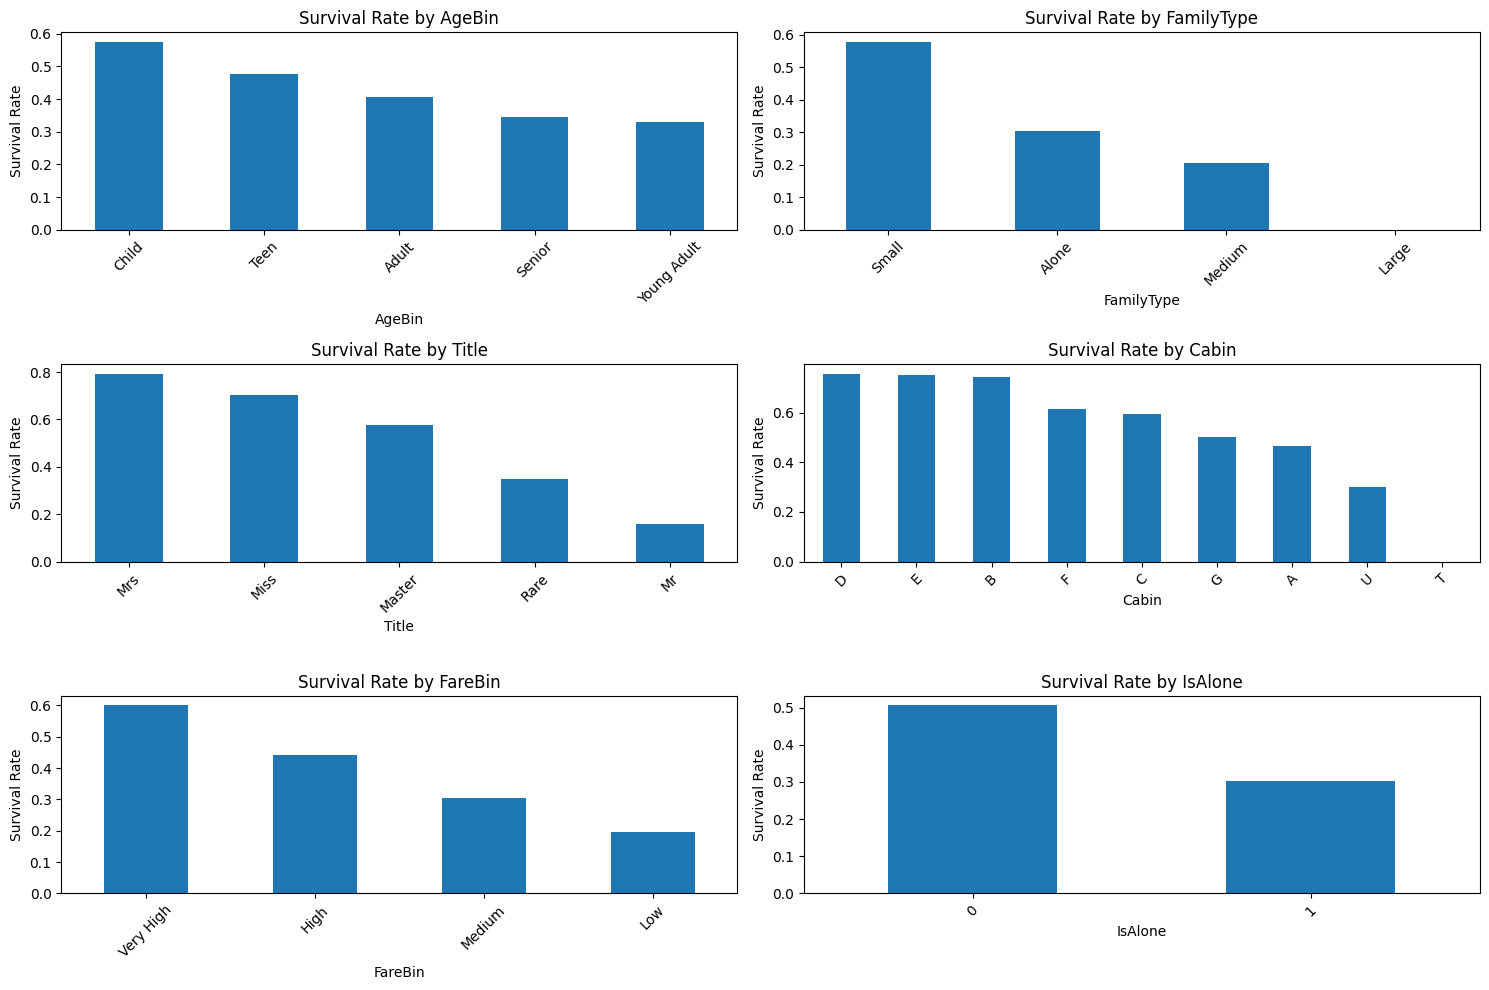

In [45]:
# Analyze new feature realtionship with survival
def plot_survival_rates(df, features):
    n_features = len(features)
    rows = (n_features + 1) // 2

    plt.figure(figsize=(15, 10))

    for i, feature in enumerate(features, 1):
        plt.subplot(rows, 2, i)
        survival_rates = df.groupby(feature)['Survived'].mean().sort_values(ascending=False)
        survival_rates.plot(kind='bar')
        plt.title(f'Survival Rate by {feature}')
        plt.ylabel('Survival Rate')
        plt.xticks(rotation=45)

    plt.tight_layout()

new_features = ['AgeBin', 'FamilyType', 'Title', 'Cabin', 'FareBin', 'IsAlone']
plot_survival_rates(train_processed, new_features)